In [1]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import pandas as pd 
import numpy as np
import geopandas as gpd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import math

In [2]:
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

# Excercise

In [3]:
releases = gpd.read_file("geospatial-learn-course-data/toxic_release_pennsylvania/toxic_release_pennsylvania/toxic_release_pennsylvania.shp") 
releases.head()

/Users/shawnspokemonworld/anaconda3/lib/python3.9/site-packages/geopandas/array.py:107: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.from_shapely(data))


,YEAR,CITY,COUNTY,ST,LATITUDE,LONGITUDE,CHEMICAL,UNIT_OF_ME,TOTAL_RELE,geometry
0,2016,PHILADELPHIA,PHILADELPHIA,PA,40.005901,-75.072103,FORMIC ACID,Pounds,0.160,POINT (2718560.227 256380.179)
1,2016,PHILADELPHIA,PHILADELPHIA,PA,39.920120,-75.146410,ETHYLENE GLYCOL,Pounds,13353.480,POINT (2698674.606 224522.905)
2,2016,PHILADELPHIA,PHILADELPHIA,PA,40.023880,-75.220450,CERTAIN GLYCOL ETHERS,Pounds,104.135,POINT (2676833.394 261701.856)
3,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,LEAD COMPOUNDS,Pounds,1730.280,POINT (2684030.004 221697.388)
4,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,BENZENE,Pounds,39863.290,POINT (2684030.004 221697.388)


In [4]:
stations = gpd.read_file("geospatial-learn-course-data/PhillyHealth_Air_Monitoring_Stations/PhillyHealth_Air_Monitoring_Stations/PhillyHealth_Air_Monitoring_Stations.shp")
stations.head()

/Users/shawnspokemonworld/anaconda3/lib/python3.9/site-packages/geopandas/array.py:107: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.from_shapely(data))


,SITE_NAME,ADDRESS,BLACK_CARB,ULTRAFINE_,CO,SO2,OZONE,NO2,NOY_NO,PM10,...,PAMS_VOC,TSP_11101,TSP_METALS,TSP_LEAD,TOXICS_TO1,MET,COMMUNITY_,LATITUDE,LONGITUDE,geometry
0,LAB,1501 East Lycoming Avenue,N,N,Y,N,Y,Y,Y,N,...,Y,N,Y,N,y,N,N,40.008606,-75.097624,POINT (2711384.641 257149.310)
1,ROX,Eva and Dearnley Streets,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,40.050461,-75.236966,POINT (2671934.290 271248.900)
2,NEA,Grant Avenue and Ashton Street,N,N,N,N,Y,N,N,N,...,N,N,N,N,N,Y,N,40.072073,-75.013128,POINT (2734326.638 280980.247)
3,CHS,500 South Broad Street,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,39.944510,-75.165442,POINT (2693078.580 233247.101)
4,NEW,2861 Lewis Street,N,N,Y,Y,Y,N,Y,Y,...,N,Y,N,Y,N,Y,N,39.991688,-75.080378,POINT (2716399.773 251134.976)


In [5]:
print(stations.crs)
print(releases.crs)

epsg:2272
epsg:2272


In [6]:
# create a buffer of 2 miles
two_mile_buffer = stations.geometry.buffer(2*5280)
two_mile_buffer.head()

0    POLYGON ((2721944.641 257149.310, 2721893.792 ...
1    POLYGON ((2682494.290 271248.900, 2682443.441 ...
2    POLYGON ((2744886.638 280980.247, 2744835.789 ...
3    POLYGON ((2703638.580 233247.101, 2703587.731 ...
4    POLYGON ((2726959.773 251134.976, 2726908.924 ...
dtype: geometry

In [7]:
# Create map with release incidents and monitoring stations
m = folium.Map(location=[39.9526,-75.1652], zoom_start=11)
HeatMap(data=releases[['LATITUDE', 'LONGITUDE']], radius=15).add_to(m)
for idx, row in stations.iterrows():
    Marker([row['LATITUDE'], row['LONGITUDE']]).add_to(m)
    
# Plot each polygon on the map
# We use folium.GeoJson() to plot each polygon on a map. 
# Since folium requires coordinates in latitude and longitude, we have to convert the CRS to EPSG 4326 before plotting.
folium.GeoJson(two_mile_buffer.to_crs(epsg=4326)).add_to(m)

# Show the map
m

- Now, to test if a toxic release occurred within 2 miles of any monitoring station, we could run 12 different tests for each polygon (to check individually if it contains the point).

- But a more efficient way is to first collapse all of the polygons into a MultiPolygon object. We do this with the ***unary_union*** attribute.

Type: <class 'shapely.geometry.multipolygon.MultiPolygon'>


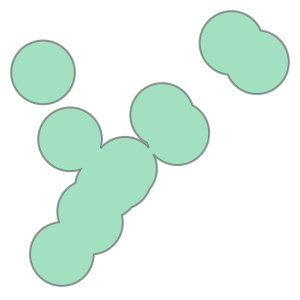

In [8]:
# Turn group of polygons into single multipolygon
my_union = two_mile_buffer.geometry.unary_union
print('Type:', type(my_union))

# Show the MultiPolygon object
my_union

In [9]:
# The closest station is less than two miles away
if_in = []
for i in range(0,len(releases)):
    if_in.append(my_union.contains(releases.iloc[i].geometry))
    releases['if_in'] = pd.Series(if_in)


In [10]:
releases.loc[releases['if_in']==False]

,YEAR,CITY,COUNTY,ST,LATITUDE,LONGITUDE,CHEMICAL,UNIT_OF_ME,TOTAL_RELE,geometry,if_in
2,2016,PHILADELPHIA,PHILADELPHIA,PA,40.023880,-75.220450,CERTAIN GLYCOL ETHERS,Pounds,104.135,POINT (2676833.394 261701.856),False
15,2016,PHILADELPHIA,PHILADELPHIA,PA,39.909720,-75.138290,PHTHALIC ANHYDRIDE,Pounds,861.000,POINT (2701063.215 220803.273),False
16,2016,PHILADELPHIA,PHILADELPHIA,PA,39.909720,-75.138290,DICYCLOPENTADIENE,Pounds,1048.000,POINT (2701063.215 220803.273),False
20,2016,PHILADELPHIA,PHILADELPHIA,PA,39.909720,-75.138290,TETRABROMOBISPHENOL A,Pounds,67.000,POINT (2701063.215 220803.273),False
22,2016,PHILADELPHIA,PHILADELPHIA,PA,40.109950,-75.002860,TOLUENE,Pounds,478.000,POINT (2736769.644 294860.891),False
...,...,...,...,...,...,...,...,...,...,...,...
4642,1987,PHILADELPHIA,PHILADELPHIA,PA,40.002530,-75.147170,"1,1,1-TRICHLOROETHANE",Pounds,14400.000,POINT (2697576.850 254524.078),False
4644,1987,PHILADELPHIA,PHILADELPHIA,PA,40.014534,-75.056562,SODIUM HYDROXIDE (SOLUTION),Pounds,250.000,POINT (2722815.906 259655.947),False
4647,1987,PHILADELPHIA,PHILADELPHIA,PA,40.029220,-75.025480,PHTHALIC ANHYDRIDE,Pounds,1250.000,POINT (2731352.864 265270.280),False
4655,1987,PHILADELPHIA,PHILADELPHIA,PA,40.109720,-75.034785,NICKEL,Pounds,840.000,POINT (2727846.852 294501.024),False


In [11]:
releases.loc[releases['if_in']==True]

,YEAR,CITY,COUNTY,ST,LATITUDE,LONGITUDE,CHEMICAL,UNIT_OF_ME,TOTAL_RELE,geometry,if_in
0,2016,PHILADELPHIA,PHILADELPHIA,PA,40.005901,-75.072103,FORMIC ACID,Pounds,0.16,POINT (2718560.227 256380.179),True
1,2016,PHILADELPHIA,PHILADELPHIA,PA,39.920120,-75.146410,ETHYLENE GLYCOL,Pounds,13353.48,POINT (2698674.606 224522.905),True
3,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,LEAD COMPOUNDS,Pounds,1730.28,POINT (2684030.004 221697.388),True
4,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,BENZENE,Pounds,39863.29,POINT (2684030.004 221697.388),True
5,2016,PHILADELPHIA,PHILADELPHIA,PA,39.889270,-75.187390,ETHYLBENZENE,Pounds,30241.00,POINT (2687511.111 212953.378),True
...,...,...,...,...,...,...,...,...,...,...,...
4658,1987,PHILADELPHIA,PHILADELPHIA,PA,40.011090,-75.120810,NAPHTHALENE,Pounds,250.00,POINT (2704865.537 257859.679),True
4659,1987,PHILADELPHIA,PHILADELPHIA,PA,40.004738,-75.113728,SODIUM HYDROXIDE (SOLUTION),Pounds,250.00,POINT (2706917.492 255605.917),True
4660,1987,PHILADELPHIA,PHILADELPHIA,PA,39.901577,-75.203163,SODIUM HYDROXIDE (SOLUTION),Pounds,250.00,POINT (2682957.516 217306.705),True
4661,1987,PHILADELPHIA,PHILADELPHIA,PA,39.978000,-75.119050,LEAD,Pounds,332.00,POINT (2705717.380 245825.600),True


# Crisis Respond

## Visualize the collision data

In [12]:
collisions = gpd.read_file("geospatial-learn-course-data/NYPD_Motor_Vehicle_Collisions/NYPD_Motor_Vehicle_Collisions/NYPD_Motor_Vehicle_Collisions.shp")
collisions.head()

/Users/shawnspokemonworld/anaconda3/lib/python3.9/site-packages/geopandas/array.py:107: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.from_shapely(data))


,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET,CROSS STRE,OFF STREET,...,CONTRIBU_2,CONTRIBU_3,CONTRIBU_4,UNIQUE KEY,VEHICLE TY,VEHICLE _1,VEHICLE _2,VEHICLE _3,VEHICLE _4,geometry
0,07/30/2019,0:00,BRONX,10464,40.841100,-73.784960,"(40.8411, -73.78496)",NaN,NaN,121 PILOT STREET,...,Unspecified,NaN,NaN,4180045,Sedan,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,POINT (1043750.211 245785.815)
1,07/30/2019,0:10,QUEENS,11423,40.710827,-73.770660,"(40.710827, -73.77066)",JAMAICA AVENUE,188 STREET,NaN,...,NaN,NaN,NaN,4180007,Sedan,Sedan,NaN,NaN,NaN,POINT (1047831.185 198333.171)
2,07/30/2019,0:25,NaN,NaN,40.880318,-73.841286,"(40.880318, -73.841286)",BOSTON ROAD,NaN,NaN,...,NaN,NaN,NaN,4179575,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (1028139.293 260041.178)
3,07/30/2019,0:35,MANHATTAN,10036,40.756744,-73.984590,"(40.756744, -73.98459)",NaN,NaN,155 WEST 44 STREET,...,NaN,NaN,NaN,4179544,Box Truck,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (988519.261 214979.320)
4,07/30/2019,10:00,BROOKLYN,11223,40.600090,-73.965910,"(40.60009, -73.96591)",AVENUE T,OCEAN PARKWAY,NaN,...,NaN,NaN,NaN,4180660,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN,POINT (993716.669 157907.212)


In [14]:
m2 = folium.Map(location=[40.7, -74], zoom_start=11) 

HeatMap(data=collisions[['LATITUDE', 'LONGITUDE']], radius=10).add_to(m2)

embed_map(m2, "q_2.html")

## Understand hospital coverage

In [15]:
hospitals = gpd.read_file("geospatial-learn-course-data/nyu_2451_34494/nyu_2451_34494/nyu_2451_34494.shp")
hospitals.head()

/Users/shawnspokemonworld/anaconda3/lib/python3.9/site-packages/geopandas/array.py:107: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.from_shapely(data))


,id,name,address,zip,factype,facname,capacity,capname,bcode,xcoord,ycoord,latitude,longitude,geometry
0,317000001H1178,BRONX-LEBANON HOSPITAL CENTER - CONCOURSE DIVI...,1650 Grand Concourse,10457,3102,Hospital,415,Beds,36005,1008872.0,246596.0,40.843490,-73.911010,POINT (1008872.000 246596.000)
1,317000001H1164,BRONX-LEBANON HOSPITAL CENTER - FULTON DIVISION,1276 Fulton Ave,10456,3102,Hospital,164,Beds,36005,1011044.0,242204.0,40.831429,-73.903178,POINT (1011044.000 242204.000)
2,317000011H1175,CALVARY HOSPITAL INC,1740-70 Eastchester Rd,10461,3102,Hospital,225,Beds,36005,1027505.0,248287.0,40.848060,-73.843656,POINT (1027505.000 248287.000)
3,317000002H1165,JACOBI MEDICAL CENTER,1400 Pelham Pkwy,10461,3102,Hospital,457,Beds,36005,1027042.0,251065.0,40.855687,-73.845311,POINT (1027042.000 251065.000)
4,317000008H1172,LINCOLN MEDICAL & MENTAL HEALTH CENTER,234 E 149 St,10451,3102,Hospital,362,Beds,36005,1005154.0,236853.0,40.816758,-73.924478,POINT (1005154.000 236853.000)


In [17]:
m3 = folium.Map(location=[40.7, -74], zoom_start=11) 

for i,j in hospitals.iterrows():
    Marker([j['latitude'],j['longitude']]).add_to(m3)
        
embed_map(m3, "q_2.html")

## When was the closest hospital more than 10 kilometers away?

In [20]:
coverage = gpd.GeoDataFrame(geometry=hospitals.geometry).buffer(10000)
hos_union = coverage.geometry.unary_union
not_cover = collisions.loc[~collisions["geometry"].apply(lambda x: hos_union.contains(x))]

In [21]:
percentage = round(100*len(not_cover)/len(collisions), 2)
print("Percentage of collisions more than 10 km away from the closest hospital: {}%".format(percentage))

Percentage of collisions more than 10 km away from the closest hospital: 15.12%


## Recommender

We decide to create a recommender that:

- Takes the location of the crash (in EPSG 2263) as input;

- Finds the closest hospital (where distance calculations are done in EPSG 2263);

- Returns the name of the closest hospital.

In [22]:
def best_hospital(collision_location):
    idx_min = hospitals.geometry.distance(collision_location).idxmin()
    rec_hos = hospitals.iloc[idx_min]
    name = rec_hos["name"]
    return name

In [24]:
highest_demand = not_cover.geometry.apply(best_hospital)

In [28]:
highest_demand.value_counts().idxmax()

'JAMAICA HOSPITAL MEDICAL CENTER'